# Import

In [1]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import (AutoTokenizer, BertTokenizer, BertForSequenceClassification, 
                          PreTrainedModel, DistilBertModel, DistilBertForSequenceClassification,
                          TrainingArguments, Trainer)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import pipeline
from transformers import set_seed
from datasets import DatasetDict
from transformers import AdamW, get_scheduler
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score


# Dataset

In [8]:
data_files = {"train": "data_clean_all _one_hot_labels_custom_347.csv"}
raw_dataset=load_dataset("HFFErica/topic_classification", data_files = data_files)
print(raw_dataset)

Using custom data configuration HFFErica--topic_classification-47e1f24e96c23b4f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:/Users/researcher/.cache/huggingface/datasets/HFFErica___csv/HFFErica--topic_classification-47e1f24e96c23b4f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


D:\Software\Anaconda3\envs\pytorch\lib\site-packages\datasets\download\streaming_download_manager.py:697: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'Order ', '1_Physical', '2_Computational', '2_1_Movement-related mechanics', '2_2_Combat-related mechanics', '2_3_Economic-related mechanics', '2_4_Story-related mechanics', '2_5_Creative-related mechanics', '3_Communicational', '4_Experiential', '4_1_Motivation', '4_2_Socialisation', '5_Player', '6_External', '7_Overall', 'sum'],
        num_rows: 1352
    })
})


In [9]:
raw_columns = raw_dataset['train'].column_names
keep_columns = ['text', '1_Physical', '2_Computational', '2_1_Movement-related mechanics', '2_2_Combat-related mechanics', '2_3_Economic-related mechanics', '2_4_Story-related mechanics', '2_5_Creative-related mechanics', '3_Communicational', '4_Experiential', '4_1_Motivation', '4_2_Socialisation', '5_Player', '6_External', '7_Overall']
remove_columns = set(raw_columns)-set(keep_columns)

preprocessed_datasets = raw_dataset.remove_columns(remove_columns)
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', '1_Physical', '2_Computational', '2_1_Movement-related mechanics', '2_2_Combat-related mechanics', '2_3_Economic-related mechanics', '2_4_Story-related mechanics', '2_5_Creative-related mechanics', '3_Communicational', '4_Experiential', '4_1_Motivation', '4_2_Socialisation', '5_Player', '6_External', '7_Overall'],
        num_rows: 1352
    })
})

In [10]:
column_mapping = {column:column.split('_')[1] for column in keep_columns if column.startswith('target')}
print(f"COLUMN_MAPPING: {column_mapping}")

preprocessed_datasets = preprocessed_datasets.rename_columns(column_mapping)
preprocessed_datasets

COLUMN_MAPPING: {}


DatasetDict({
    train: Dataset({
        features: ['text', '1_Physical', '2_Computational', '2_1_Movement-related mechanics', '2_2_Combat-related mechanics', '2_3_Economic-related mechanics', '2_4_Story-related mechanics', '2_5_Creative-related mechanics', '3_Communicational', '4_Experiential', '4_1_Motivation', '4_2_Socialisation', '5_Player', '6_External', '7_Overall'],
        num_rows: 1352
    })
})

In [11]:
# get two-way label and label id
ID2LABEL = {}
LABEL2ID = {}

label_id = 0
for label in preprocessed_datasets['train'].features.keys():
    if label in ['text']:
        continue
        
    ID2LABEL[label_id] = label
    LABEL2ID[label] = label_id
    
    label_id += 1
    
print(f"ID2LABEL:\n{ID2LABEL}\n")
print(f"LABEL2ID:\n{LABEL2ID}")

ID2LABEL:
{0: '1_Physical', 1: '2_Computational', 2: '2_1_Movement-related mechanics', 3: '2_2_Combat-related mechanics', 4: '2_3_Economic-related mechanics', 5: '2_4_Story-related mechanics', 6: '2_5_Creative-related mechanics', 7: '3_Communicational', 8: '4_Experiential', 9: '4_1_Motivation', 10: '4_2_Socialisation', 11: '5_Player', 12: '6_External', 13: '7_Overall'}

LABEL2ID:
{'1_Physical': 0, '2_Computational': 1, '2_1_Movement-related mechanics': 2, '2_2_Combat-related mechanics': 3, '2_3_Economic-related mechanics': 4, '2_4_Story-related mechanics': 5, '2_5_Creative-related mechanics': 6, '3_Communicational': 7, '4_Experiential': 8, '4_1_Motivation': 9, '4_2_Socialisation': 10, '5_Player': 11, '6_External': 12, '7_Overall': 13}


In [12]:
# get target label counts and percentages
label_counts = {}
label_percentages = {}

for label in LABEL2ID:
    label_counts[label] = sum(preprocessed_datasets['train'][label])
    label_percentages[label] = float(f"{sum(preprocessed_datasets['train'][label]) / len(preprocessed_datasets['train'])*100:.2f}")

print(f"LABEL_COUNTS:\n{label_counts}\n")
print(f"LABEL_PERCENTAGES:\n{label_percentages}")

LABEL_COUNTS:
{'1_Physical': 270, '2_Computational': 198, '2_1_Movement-related mechanics': 108, '2_2_Combat-related mechanics': 92, '2_3_Economic-related mechanics': 92, '2_4_Story-related mechanics': 148, '2_5_Creative-related mechanics': 116, '3_Communicational': 284, '4_Experiential': 293, '4_1_Motivation': 159, '4_2_Socialisation': 191, '5_Player': 164, '6_External': 205, '7_Overall': 279}

LABEL_PERCENTAGES:
{'1_Physical': 19.97, '2_Computational': 14.64, '2_1_Movement-related mechanics': 7.99, '2_2_Combat-related mechanics': 6.8, '2_3_Economic-related mechanics': 6.8, '2_4_Story-related mechanics': 10.95, '2_5_Creative-related mechanics': 8.58, '3_Communicational': 21.01, '4_Experiential': 21.67, '4_1_Motivation': 11.76, '4_2_Socialisation': 14.13, '5_Player': 12.13, '6_External': 15.16, '7_Overall': 20.64}


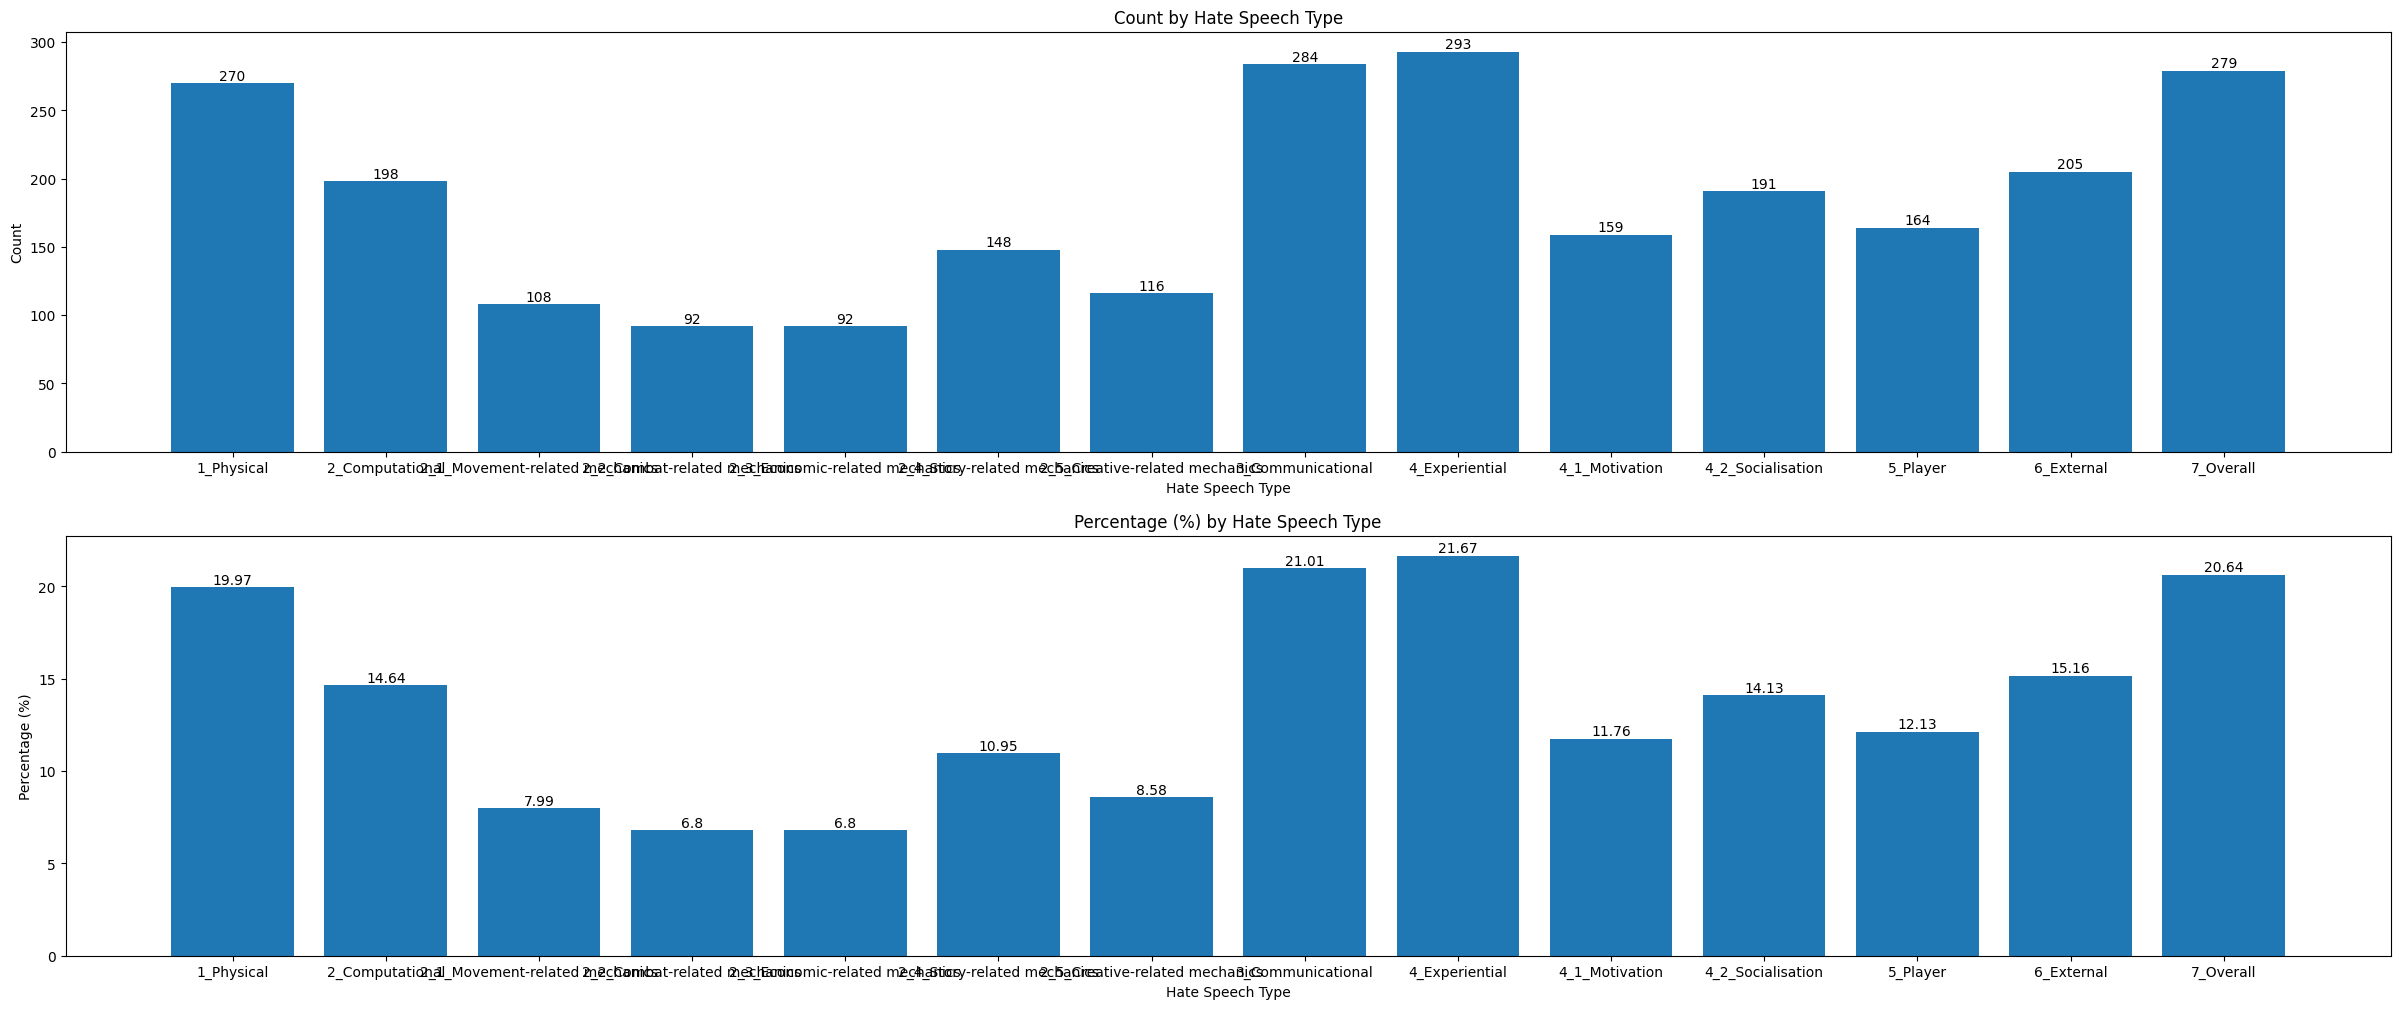

In [13]:
import matplotlib.pyplot as plt

# create 2 graphs
fig, axs = plt.subplots(2, figsize=(30,12))

# create bar graphs of label counts
bar_container0 = axs[0].bar(label_counts.keys(), label_counts.values())
axs[0].bar_label(bar_container0, label_type='edge')
axs[0].set_xlabel('Hate Speech Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Count by Hate Speech Type')

# create bar graphs of label percentages
bar_container1 = axs[1].bar(label_percentages.keys(), label_percentages.values())
axs[1].bar_label(bar_container1, label_type='edge')
axs[1].set_xlabel('Hate Speech Type')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Percentage (%) by Hate Speech Type')

plt.show()

In [14]:
def create_labels(batch):
    # one-hot encode targets for training
    batch['labels'] = [[float(batch[label][i]) for label in LABEL2ID] for i in range(len(batch['text']))]
    return batch

preprocessed_datasets = preprocessed_datasets.map(create_labels, batched=True, remove_columns=LABEL2ID.keys())
preprocessed_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1352
    })
})

In [15]:
df = preprocessed_datasets['train'].to_pandas()
# df = df.drop('Unnamed: 27', axis=1)
df

,text,labels
0,"Sharing stories, trading goods, or engaging in...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1,Doing missions at the nexus with other players...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,"Not just because of the scale of the worlds, b...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,When you initiate some orders like deploy ligh...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,Stopped playing it after the inventory UI upda...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...
1347,my laptop is not good enough to play it on the...,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1348,Fighting enemies who are quick to react - even...,"[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1349,"Ship can't change weapons, can't lock on to en...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
1350,I purchased this for cross-play as a beforehan...,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Setup Model Training

In [16]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [17]:
train_test_datasets = preprocessed_datasets['train'].train_test_split(test_size=0.2, seed=SEED, shuffle=True)
validation_test_datasets = train_test_datasets['test'].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

preprocessed_datasets = DatasetDict({
    'train': train_test_datasets['train'],
    'validation': validation_test_datasets['train'],
    'test': validation_test_datasets['test']
})
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1081
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 135
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 136
    })
})

In [18]:
CHECKPOINT = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
tokenized_datasets = preprocessed_datasets.map(lambda batch: tokenizer(batch['text'], truncation=True), batched=True, remove_columns=['text'])
tokenized_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1081
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 135
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 136
    })
})

In [19]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# get data collator for data loader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# setup dataloaders with tokenized dataset
# to shuffle only be train for each epoch
# in 64 batch sizes with dynamic padding

dataloaders = {}
for dataset_type in tokenized_datasets.keys():
    dataloaders[dataset_type] = DataLoader(
        dataset=tokenized_datasets[dataset_type],
        batch_size=64,
        shuffle=(dataset_type == 'train'), 
        collate_fn=data_collator,
    )

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT,
    problem_type='multi_label_classification',
    num_labels=len(LABEL2ID),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)

# move model to device
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [22]:
# setup optimizer and scheduler
scheduler_name = 'linear'
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0, no_deprecation_warning=True)
num_training_epochs = 1
num_training_steps = num_training_epochs * len(dataloaders['train'])
num_warmup_steps = 0
lr_scheduler = get_scheduler(
    name=scheduler_name,
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

print(f"           SCHEDULER NAME: {scheduler_name}")
print(f"                OPTIMIZER: {optimizer.__class__.__name__}")
print(f"NUMBER OF TRAINING EPOCHS: {num_training_epochs}")
print(f" NUMBER OF TRAINING STEPS: {num_training_steps}")

           SCHEDULER NAME: linear
                OPTIMIZER: AdamW
NUMBER OF TRAINING EPOCHS: 1
 NUMBER OF TRAINING STEPS: 17


In [23]:
def samples_accuracy_score(y_true, y_pred):
    return np.sum(y_true==y_pred) / y_true.size

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = torch.nn.functional.sigmoid(torch.Tensor(logits))
    predictions = (predictions >= 0.50).int().numpy()
    samples_accuracy = samples_accuracy_score(labels, predictions)
    samples_f1 = f1_score(labels, predictions, average='samples', zero_division=0)
    return {
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

In [24]:
def train(model, dataloader):
    # setup train metrics
    loss = 0
    train_predictions = []
    train_labels = []
    
    # set to train mode
    model.train()
    # iterate through dataloader
    for batch in tqdm(dataloader):
        # zero the gradients
        optimizer.zero_grad()
        
        # predict batch in current device
        batch.to(device)
        outputs = model(**batch)
        
        # compute multilabel outputs
        predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
        predictions = (predictions >= 0.50).int().numpy()
        labels = batch['labels']
        
        # backprop and update learning rate
        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        # accumulate train metrics
        loss += outputs.loss.item()
        train_predictions += predictions.tolist()
        train_labels += labels.tolist()
        
    # compute train metrics
    loss /= len(dataloader)
    samples_accuracy = samples_accuracy_score(np.array(train_labels), np.array(train_predictions))

    
    
    
#     train_labels = np.argmax(train_labels, axis=1)
#     train_predictions = np.argmax(train_predictions, axis=1)
    
    samples_f1 = f1_score(np.array(train_labels), np.array(train_predictions), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

In [25]:
def evaluate(model, dataloader):
    # setup evaluation metrics variables
    loss = 0
    evaluate_predictions = []
    evaluate_labels = []
    
    # set to evaluation mode
    model.eval()
    with torch.no_grad():
        # iterate through dataloader
        for batch in tqdm(dataloader):
            # predict batch in current device
            batch.to(device)
            outputs = model(**batch)
            
            # compute multilabel outputs
            predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
            predictions = (predictions >= 0.50).cpu().numpy()
            labels = batch['labels']
            
            # accumulate evaluation metrics
            loss += outputs.loss.item()
            evaluate_predictions += predictions.tolist()
            evaluate_labels += labels.tolist()
            
    # compute evaluation metrics
    loss /= len(dataloader)
    samples_accuracy = samples_accuracy_score(np.array(evaluate_labels), np.array(evaluate_predictions))
    samples_f1 = f1_score(np.array(evaluate_labels), np.array(evaluate_predictions), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

# Train

In [26]:
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" | ")
print(f"TEST F1: {test_metrics['f1']:.5f}")

  0%|          | 0/3 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


TEST ACCURACY: 0.49580 | TEST F1: 0.19977


In [27]:
for epoch in range(num_training_epochs):
    train_metrics = train(model, dataloaders['train'])
    validation_metrics = evaluate(model, dataloaders['validation'])
          
    print(f"EPOCH {epoch+1}", end=" | ")
    print(f"TRAIN LOSS: {train_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION LOSS: {validation_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION ACCURACY: {validation_metrics['accuracy']:.5f}", end=" | ")
    print(f"VALIDATION F1: {validation_metrics['f1']:.5f}")

  0%|          | 0/17 [00:00<?, ?it/s]

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/3 [00:00<?, ?it/s]

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH 1 | TRAIN LOSS: 0.60769 | VALIDATION LOSS: 0.54563 | VALIDATION ACCURACY: 0.85450 | VALIDATION F1: 0.00000


In [28]:
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" | ")
print(f"TEST F1: {test_metrics['f1']:.5f}")

  0%|          | 0/3 [00:00<?, ?it/s]

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


TEST ACCURACY: 0.86134 | TEST F1: 0.00000


In [29]:
model.push_to_hub("my_model_Eperiment6")
tokenizer.push_to_hub("my_model_Eperiment6")

CommitInfo(commit_url='https://huggingface.co/HFFErica/my_model_Eperiment6/commit/42b78bcf4674ac022ffdb9e1187d80690a5274ec', commit_message='Upload tokenizer', commit_description='', oid='42b78bcf4674ac022ffdb9e1187d80690a5274ec', pr_url=None, pr_revision=None, pr_num=None)

# Exam

In [33]:
pipe = pipeline("text-classification", model="HFFErica/my_model_Eperiment6")

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\researcher\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [36]:
results_01 = pipe("I have been able to achieve a admirable framerate at max settings, especially for a rig that is becoming outdated.")
print(results_01)

results_02 = pipe("This isn't surprising given the scope of the game and the fact that it's developed by a very small team, but it is frustrating that in VR my 1080ti can only play the game at medium graphics settings.")
print(results_02)

results_03 = pipe("My pc meets the recommended requirements exactly with amd cpu and gpu. On most maps I have to have my resolution and all graphics settings all the way down and the game still stutters and lags.")
print(results_03)

results_04 = pipe("Because the game was primarily developed and optimized for PlayStation 4 (which has 8 cores), it needs 8 threads or 8 cores to function properly. The system requirement of a Core i3 is nonsense. I know of no Core i3 or similar low-spec AMD CPU that has 8 threads available.")
print(results_04)
results_05 = pipe("I also noticed a audio glitch in the twitch live stream, its like the audio was repeating itself, so I reset the game and it was back to normal.")
print(results_05)

results_06 = pipe("If you play permadeath you can literally wind up doing nothing but the tutorial over and over again because you can get killed easily during the tutorial. Of course you can cheat a permadeath defeat by the simple method of backing up your permadeath game file before beginning your play session.")
print(results_06)

[{'label': '3_Communicational', 'score': 0.453117311000824}]
[{'label': '3_Communicational', 'score': 0.4573950171470642}]
[{'label': '3_Communicational', 'score': 0.4537425935268402}]
[{'label': '3_Communicational', 'score': 0.462228924036026}]
[{'label': '3_Communicational', 'score': 0.4459535777568817}]
[{'label': '3_Communicational', 'score': 0.46061059832572937}]


In [30]:
multilabel_classifier = pipeline(
    task='text-classification',
    model=model,
    tokenizer=tokenizer,
    device=torch.cuda.current_device(),
    top_k=None
)

In [38]:
results_01 = multilabel_classifier("I have been able to achieve a admirable framerate at max settings, especially for a rig that is becoming outdated.")
results_02 = multilabel_classifier("This isn't surprising given the scope of the game and the fact that it's developed by a very small team, but it is frustrating that in VR my 1080ti can only play the game at medium graphics settings.")
results_03 = multilabel_classifier("My pc meets the recommended requirements exactly with amd cpu and gpu. On most maps I have to have my resolution and all graphics settings all the way down and the game still stutters and lags.")
results_04 = multilabel_classifier("Because the game was primarily developed and optimized for PlayStation 4 (which has 8 cores), it needs 8 threads or 8 cores to function properly. The system requirement of a Core i3 is nonsense. I know of no Core i3 or similar low-spec AMD CPU that has 8 threads available.")
results_05 = multilabel_classifier("I also noticed a audio glitch in the twitch live stream, its like the audio was repeating itself, so I reset the game and it was back to normal.")
results_06 = multilabel_classifier("If you play permadeath you can literally wind up doing nothing but the tutorial over and over again because you can get killed easily during the tutorial. Of course you can cheat a permadeath defeat by the simple method of backing up your permadeath game file before beginning your play session.")
print(results_01)
print(results_02)
print(results_03)
print(results_04)
print(results_05)
print(results_06)

[[{'label': '3_Communicational', 'score': 0.453117311000824}, {'label': '2_3_Economic-related mechanics', 'score': 0.42864537239074707}, {'label': '7_Overall', 'score': 0.42002540826797485}, {'label': '4_Experiential', 'score': 0.41061481833457947}, {'label': '2_5_Creative-related mechanics', 'score': 0.4082336127758026}, {'label': '4_1_Motivation', 'score': 0.40335679054260254}, {'label': '6_External', 'score': 0.3892900347709656}, {'label': '4_2_Socialisation', 'score': 0.3874954581260681}, {'label': '1_Physical', 'score': 0.38557538390159607}, {'label': '5_Player', 'score': 0.36955496668815613}, {'label': '2_1_Movement-related mechanics', 'score': 0.36402469873428345}, {'label': '2_4_Story-related mechanics', 'score': 0.3544168770313263}, {'label': '2_2_Combat-related mechanics', 'score': 0.35371652245521545}, {'label': '2_Computational', 'score': 0.3418140113353729}]]
[[{'label': '3_Communicational', 'score': 0.4573950171470642}, {'label': '7_Overall', 'score': 0.41054248809814453}

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
